# `holodeck` - Semi-Analytic Models

For more information on the holodeck SAMs, see the [holodeck getting started guide](https://holodeck-gw.readthedocs.io/en/main/getting_started/index.html).

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm

import holodeck as holo
from holodeck import sams
from holodeck import utils, plot
from holodeck.constants import MSOL, YR

holo.log.setLevel(holo.log.ERROR)

## Quick Start

Construct a Semi-Analytic Model (SAM) using all of the default components

In [4]:
# Specify the shape of the SAM grid to be a small number (e.g. `30`), so that this example runs quickly
# (although with low accuracy).
sam = sams.Semi_Analytic_Model(shape=100)

Choose the edges of the frequency bins at which to calculate the GWB

In [3]:
OBS_DUR = 10.0 * YR    # duration of PTA observations in [sec], which determines the Fourier frequency basis
NUM_FREQS = 20         # number of frequency bins
fobs, fobs_edges = utils.pta_freqs(dur=OBS_DUR, num=NUM_FREQS)
print(f"Number of frequency bins: {fobs.size}")
print(f"  between [{fobs[0]*YR:.2f}, {fobs[-1]*YR:.2f}] 1/yr")
print(f"          [{fobs[0]*1e9:.2f}, {fobs[-1]*1e9:.2f}] nHz")

Number of frequency bins: 20
  between [0.10, 2.00] 1/yr
          [3.17, 63.38] nHz


Calculate GWB from this SAM.  
We need to specify the edges of the frequency bins that are being observed (`fobs_edges`).  
We also ask for many different 'realizations' of the universe to get a distribution of expected amplitudes.  
And finally we will obtain a handful of the 'loudest' binaries in each frequency bin, ('single sources'),  in addition to the sum of the characteristic strains of all remaining binaries (the background).


In [5]:
NUM_REALS = 1000    # Number of 'realizations' to generate
NUM_LOUDEST = 10   # Number of 'loudest' binaries to generate in each frequency bin
hc_ss, hc_bg = sam.gwb(fobs_edges, realize=NUM_REALS, loudest=NUM_LOUDEST)

Plot GWB over multiple realizations

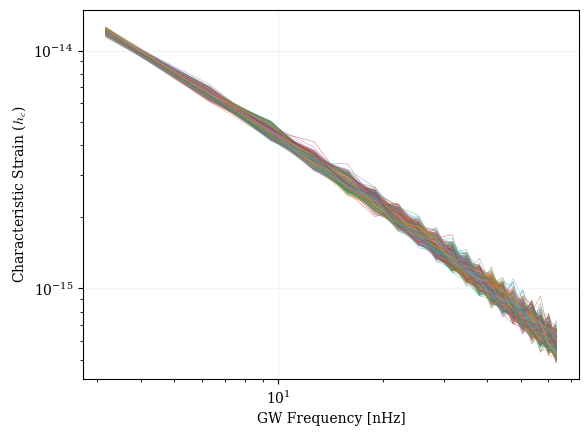

In [6]:
plt.loglog(fobs*1e9, hc_bg, lw=0.5, alpha=0.5);
plt.gca().set(ylabel='Characteristic Strain ($h_c$)', xlabel='GW Frequency [nHz]')
plt.show()

Slightly fancier plot:

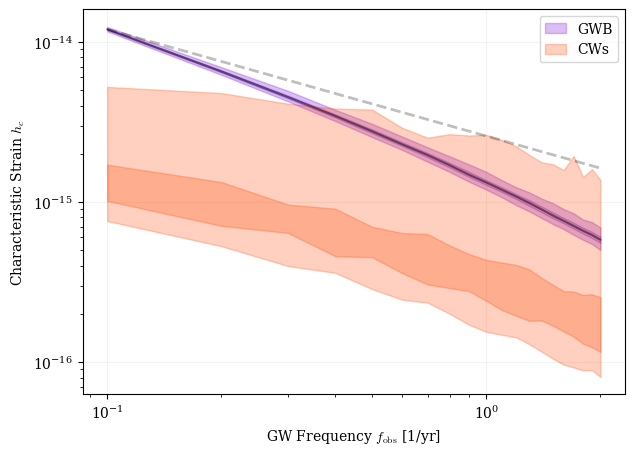

In [8]:
fig, ax = plot.figax(xlabel='GW Frequency $f_\mathrm{obs}$ [1/yr]', ylabel='Characteristic Strain $h_c$')

# `fobs` are bin centers in CGS units, convert to [1/yr]
xx = fobs * YR

# Get the median over all the realizations
med = np.median(hc_bg, axis=-1)

# plot a reference, pure power-law  strain spectrum:   h_c(f) = A * (f * yr) ^ -2/3
yy = med[0] * np.power(xx/xx[0], -2.0/3.0)
ax.plot(xx, yy, 'k--', alpha=0.25, lw=2.0)

# Plot the median GWB spectrum
ax.plot(xx, med, 'k-', alpha=0.5)

# Combine the `loudest` binaries in all realizations, to get distributions of their strains
singles = hc_ss.reshape((hc_ss.shape[0], -1))

# Plot distributions of GWB and Continuous Wave (CW) strains over all realizations
# contours at 50% and 98% confidence intervals
for pp in [50, 98]:
    percs = pp / 2
    percs = [50 - percs, 50 + percs]
    h1 = ax.fill_between(xx, *np.percentile(hc_bg, percs, axis=-1), alpha=0.25, color='#7100d4')
    h2 = ax.fill_between(xx, *np.percentile(singles, percs, axis=-1), alpha=0.25, color='orangered')

ax.legend([h1, h2], ['GWB', 'CWs'])
plt.show()

## Specifics

### Constructing a SAM

SAMs are built from simple analytic models to derive the number-density of MBH binaries.
To do this, we start with a **galaxy stellar-mass function (GSMF; $\psi$)** which determines the number of 
galaxies as a function of stellar mass.  We then multiply by a **galaxy merger rate (GMR; $R$)** to get
the rate of galaxy-galaxy mergers:

$$\frac{\partial^3 n_{\star\star}(M_\star, q_\star, z)}{\partial \log_{10}(M_\star) \, \partial q_\star \, \partial z} = \psi(m_{1,\star}) \cdot R(M_\star, q_\star, z).$$

Here, the total stellar-mass of both galaxies is $M_\star \equiv m_{1,\star} + m_{2,\star}$, and the stellar mass ratio is $q_\star \equiv m_{2,\star} / m_{1,\star}.$

To convert from galaxy-galaxy to MBH–MBH mergers, we use a relationship between host-galaxy and MBHs, typically in the form of an **M-Mbulge (MMB)** relationship: the MBH mass as a function of galaxy stellar-bulge mass, $M = M_{BH}(M_\star)$, so that we can write:

$$\frac{\partial^3 n(M, q, z)}{\partial \log_{10}(M) \, \partial q \, \partial z}  = \psi(m_{1,\star}) \cdot R(M_\star, q_\star, z) \cdot \frac{\partial M_\star}{\partial M} \frac{\partial q_\star}{\partial q}.$$

The GMR is very hard to determine observationally, so it's common to approximate it as the ratio of a **galaxy pair-fraction (GPF; $P$)**, and a **galaxy merger time (GMT; $T$)**, i.e. $$R(M_\star, q_\star, z) \approx \frac{P(m_{1,\star}, q_\star, z)}{T(M_\star, q_\star, z)}.$$

The SAMs are initialized over a 3-dimensional parameter space of total MBH mass ($M = m_1 + m_2$), MBH mass ratio ($q = m_2 / m_1 \leq 1$), and redshift ($z$).  The `holodeck` code typically refers to the number of bins in each of these dimensions as `M`, `Q`, and `Z`; for example, the shape of the number-density of galaxy mergers will be `(M, Q, Z)`.

In [9]:
# Specify the size of the SAM grid, with shape (M, Q, Z) for a grid of (total-mass, mass-ratio, redshift).
# We'll use a small grid so that calculations are fast (but not very accurate).
SAM_SHAPE = (100, 100, 100)


# ---- Build SAM using Galaxy Merger-Rate:

# gsmf = holo.sams.GSMF_Schechter()               # Galaxy Stellar-Mass Function (GSMF)
# gmr = holo.sams.GMR_Illustris()                 # Galaxy Merger Rate           (GMR)
# mmbulge = holo.host_relations.MMBulge_MM2013()       # M-MBulge Relation            (MMB)

# sam = holo.sams.Semi_Analytic_Model(gsmf=gsmf, gmr=gmr, mmbulge=mmbulge, shape=SAM_SHAPE)


# ---- Build SAM using Galaxy Pair-Fraction and Galaxy Merger-Time:

gsmf = holo.sams.GSMF_Schechter()               # Galaxy Stellar-Mass Function (GSMF)
gpf = holo.sams.GPF_Power_Law()                 # Galaxy Pair Fraction         (GPF)
gmt = holo.sams.GMT_Power_Law()                 # Galaxy Merger Time           (GMT)
mmbulge = holo.host_relations.MMBulge_MM2013()       # M-MBulge Relation            (MMB)

sam = holo.sams.Semi_Analytic_Model(gsmf=gsmf, gpf=gpf, gmt=gmt, mmbulge=mmbulge, shape=SAM_SHAPE)

### number density and the SAM grid

The formation rate of MBH-MBH 'binaries' is calculated in `Semi_Analytic_Model.static_binary_density`, evaluated at the edges of the grid so that it's shape is the number of bins in each dimension, plus one, i.e. `(M+1, Q+1, Z+1)`.  `static_binary_density` is implemented as a `@property` so that the first time the value is accessed it is calculated and cached, and then returned immediately on subsequent calls. 

NOTE: at this point, these are not necessarily gravitationally-bound MBH 'binaries', but instead pairs of two MBHs coming together in a galaxy-galaxy merger.

In [10]:
print(f"Calculated `static_binary_density` for the first time... (you can probably ignore all of the messages, including non-fatal 'ERROR's.)")
nden = sam.static_binary_density  # this will trigger the variable to be calculated and cached.
print(f"Shape of number density: {nden.shape}")

# `sam.edges` returns a tuple with each of the grid-edges
print(f"SAM `mtot` edges: [{sam.mtot[0]/MSOL:.1e}, {sam.mtot[-1]/MSOL:.1e}] with {sam.mtot.size} edges.")
print(f"SAM `mrat` edges: [{sam.mrat[0]:.1e}, {sam.mrat[-1]:.1e}] with {sam.mrat.size} edges.")
print(f"SAM `redz` edges: [{sam.redz[0]:.1e}, {sam.redz[-1]:.1e}] with {sam.redz.size} edges.")
# The shape of the edges is stored as `sam.shape`
print(f"SAM `shape` (variable): {sam.shape}")
# All three of the grid edges are returned as a tuple when called `sam.edges`
print(f"SAM shape (from `edges`): {[ee.size for ee in sam.edges]}")

Calculated `static_binary_density` for the first time... (you can probably ignore all of the messages, including non-fatal 'ERROR's.)
Shape of number density: (100, 100, 100)
SAM `mtot` edges: [1.0e+04, 1.0e+12] with 100 edges.
SAM `mrat` edges: [1.0e-03, 1.0e+00] with 100 edges.
SAM `redz` edges: [1.0e-03, 1.0e+01] with 100 edges.
SAM `shape` (variable): (100, 100, 100)
SAM shape (from `edges`): [100, 100, 100]


Shape of number density slice at fixed redz: (100, 100)


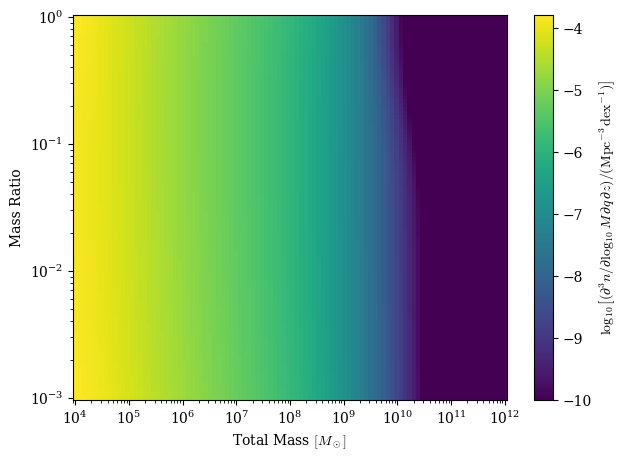

In [20]:
# Let's look at the number-density of binaries in `(M, Q)` space at a particular redshift slice
# ---------------------------------------------------------------------------------------------
redz_indx = 99   # randomly chosen redshift index number

# because `static_binary_density` was already accessed above, this call does NOT recalculate
# the density, it just returns the cached values
nden = sam.static_binary_density[:, :, redz_indx]
print(f"Shape of number density slice at fixed redz: {nden.shape}")

fig, ax = holo.plot.figax(xlabel='Total Mass $[M_\odot]$', ylabel='Mass Ratio')
# we transpose the number-density because matplotlib thinks in terms of images instead of arrays
# we're manually setting the lower-limit for the colorbar because some values are often ~0
pcm = ax.pcolormesh(sam.mtot / MSOL, sam.mrat, np.log10(nden).T, vmin=-10)

# Note that this is a distribution function (the values are ``d^3n / dlog10(M) dq dz``),
# of a volumentric number density (n = Number/Volume) and
# a rate (per unit redshfit: 1/dz).  So the units are a bit complicated:
label_units = (
    r'$\log_{10}\left['
    r'(\partial^3 n / \partial \log_{10} M \, \partial q \, \partial z)'
    r'/'
    r'(\mathrm{Mpc}^{-3} \, \mathrm{dex}^{-1})'
    r'\right]$'
)
plt.colorbar(pcm, ax=ax, label=label_units)
plt.show()

### total number of binaries in a universe

Above, we calculated the volumetric number-density rate of binary mergers.  Here, we calculate the total number of binaries in a simulated universe at particular GW frequencies of interest.  The SAM models currently assume circular binary orbits, so that the GW frequency is exactly twice the orbital frequency.

To calculate the number of binaries over frequency, we basically just use the chain rule (but note that this glances over a lot of subtle physics):

$$\frac{\partial^3 N(M, q, z, f)}{\partial \log_{10}\! M \, \partial q \, \partial z \, \partial \ln\! f} = 
\frac{\partial^3 n(M, q, z)}{\partial \log_{10}\! M \, \partial q \, \partial z}
\left( \frac{\partial V_c}{\partial z} \right) 
\left( \frac{\partial z}{\partial t} \right)
\left( \frac{\partial t}{\partial \ln\! f} \right).$$

The left-hand side is what we want.  The right-hand side has four terms.  The first is the `static_number_density` that we calculated previously.  The second is the differential comoving-volume of the universe as a function of redshift, and the third converts between the rate of time- and redshift- evolution of the universe.  The important term is the last one, called the **residence time** or **hardening time** of binaries:

$$\frac{\partial t}{\partial \ln\! f} = \frac{f}{\left( \partial f / \partial t \right)} \equiv \tau_f.$$

The way to understand this term, is that the longer binaries spend in a given frequency interval, the more likely binaries are to be found at those frequencies, and thus in a random snapshot of the universe, the more binaries will be found there.  This term requires some model for **binary evolution** (often referred to as **binary 'hardening'**).

In [21]:
# Choose frequency bins over which to calculate binaries.
# Construct frequency-bin edges
fobs_gw_edges = np.logspace(-1, 2, 31) / YR
# Calculate the mid-points of each pair of edges to use as bin-centers
fobs_gw_cents = holo.utils.midpoints(fobs_gw_edges, log=True)
print(f"{fobs_gw_cents.size} frequency bins between [{fobs_gw_edges[0]*YR:.1e}, {fobs_gw_edges[-1]*YR:.1e} 1/yr]")
print(f"{fobs_gw_cents.size} frequency bins between [{fobs_gw_edges[0]*1e9:.1e}, {fobs_gw_edges[-1]*1e9:.1e} nHz]")

30 frequency bins between [1.0e-01, 1.0e+02 1/yr]
30 frequency bins between [3.2e+00, 3.2e+03 nHz]


For each point in the 3-dimensional SAM grid, we will be calculating the number of binaries at each frequency.  So the returned values will be 4-dimensional with an additional axis with `F` frequency bins added: `(M, Q, Z, F)`.

**GW-Only Binary Evolution**

In [22]:
# construct an instance of the GW-Hardening class `Hard_GW`
hard_gw = holo.hardening.Hard_GW()

# Calculate the differential number of binaries, ``dN/[dlog10M dq qz dlnf]``
# convert from GW frequencies to orbital frequencies (still observer-frame)
fobs_orb_edges = fobs_gw_edges / 2.0
fobs_orb_cents = fobs_gw_cents / 2.0
# `diff_num` is a 4D array with shape (M+1, Q+1, Z+1, F)
# these values are evaluated at bin edges for total-mass, mass-ratio, redshift, but freq bin-centers
_edges, diff_num_gw, redz_final = sam.dynamic_binary_number_at_fobs(hard_gw, fobs_orb_cents, use_cython=False)

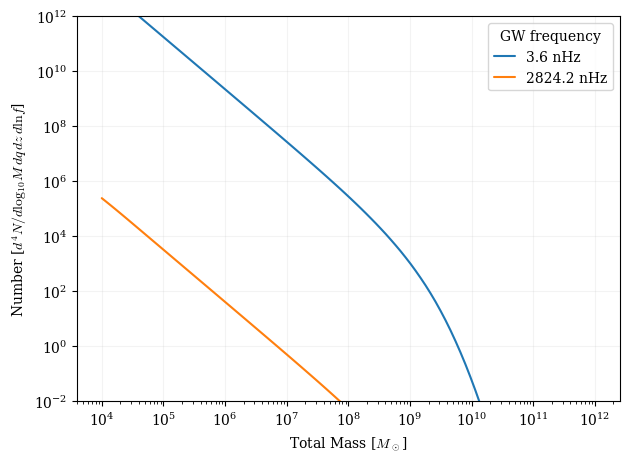

In [25]:
mrat_indx = -1   # choose mass-ratio index near unity
redz_indx = 50   # choose redshift index

# choose a few different frequency indices
fobs_indx = [0, -1]

# The 'number' of binaries is still a differential number
units = 'Number [$d^4 N/ d\log_{10}\! M \, dq \, dz \, d\ln \! f$]'

fig, ax = holo.plot.figax(xlabel='Total Mass [$M_\odot$]', ylabel=units, ylim=[1e-2, 1e12])
for fidx in fobs_indx:
    fo = fobs_gw_cents[fidx]
    num = diff_num_gw[:, mrat_indx, redz_indx, fidx]
    ax.plot(sam.mtot/MSOL, num, label=f'{fo*1e9:.1f} nHz')

ax.legend(title='GW frequency')
plt.show()

Convert from differential number of binaries to actual number of binaries

In [26]:
# Integrate the differential number over each bin to get the total number ``N`` per bin
edges = [sam.mtot, sam.mrat, sam.redz, fobs_orb_edges]
# `number` is now a 4D array with shape `(M, Q, Z, F)`
# all 4 axes are now 'bin centers', but note that the Frequency dimension did not change in shape
number_gw = holo.sams.sam_cyutils.integrate_differential_number_3dx1d(edges, diff_num_gw)

# total number of binaries in the universe
print(f"Total number of modeled binaries: {number_gw.sum():.1e}")

Total number of modeled binaries: 2.5e+14


In [27]:
nden.shape, diff_num_gw.shape, number_gw.shape

((100, 100), (100, 100, 100, 30), (99, 99, 99, 30))

Calculate the total number of binaries in certain ranges of parameter space

In [28]:
# Choose parameter bounds
mtot_extr = [1e7*MSOL, 1e11*MSOL]
mrat_extr = [0.1, np.inf]
redz_extr = [-np.inf, +np.inf]
fobs_gw_extr = [-np.inf, +np.inf]

# make some lists
extrema = [mtot_extr, mrat_extr, redz_extr, fobs_gw_extr]
# we need to compare to values at bin-centers, instead of bin-edges
centers = [holo.utils.midpoints(ee, log=True) for ee in edges]
select = [(extr[0] < cent) & (cent < extr[1]) for extr, cent in zip(extrema, centers)]
num = number_gw.copy()
# slice along each dimension
for ii in range(num.ndim):
    num = np.moveaxis(num, ii, 0)
    num = num[select[ii]]
    num = np.moveaxis(num, 0, ii)

print(f"Number of binaries = {num.sum():.2e}  |  with parameters: ")
print(f"\t{mtot_extr[0]/MSOL:.1e} < M/Msol < {mtot_extr[1]/MSOL:.1e}")
print(f"\t{mrat_extr[0]:.1e} < q < {mrat_extr[1]:.1e}")
print(f"\t{redz_extr[0]:.1e} < z < {redz_extr[1]:.1e}")
print(f"\t{fobs_gw_extr[0]:.1e} < f < {fobs_gw_extr[1]:.1e}")

Number of binaries = 1.75e+08  |  with parameters: 
	1.0e+07 < M/Msol < 1.0e+11
	1.0e-01 < q < inf
	-inf < z < inf
	-inf < f < inf


### Self-Consistent Binary Evolution (Phenomenological Model)

In [29]:
# Choose a total binary lifetime (from formation to coalescence)
lifetime = 0.1e9 * YR
# construct an instance of the 'Phenomenological' Hardening class `Fixed_Time_2PL_SAM`
hard_ph = holo.hardening.Fixed_Time_2PL_SAM(sam, lifetime)

# Calculate the differential number of binaries, ``dN/[dlog10M dq qz dlnf]``
_edges, diff_num_ph, redz_final = sam.dynamic_binary_number_at_fobs(hard_ph, fobs_orb_cents)

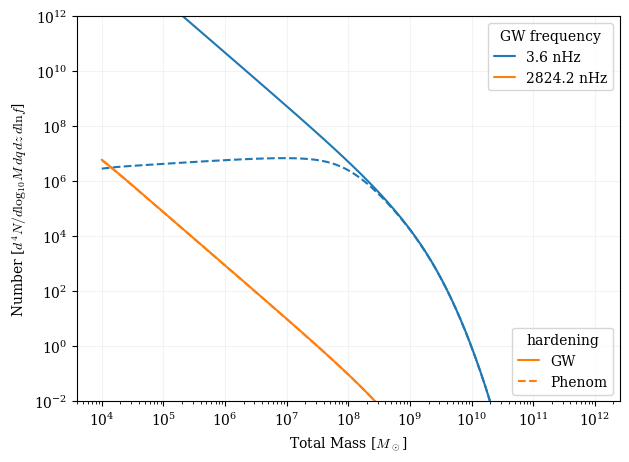

In [32]:
mrat_indx = -1   # choose mass-ratio index near unity
redz_indx = 78   # choose redshift index

# choose a few different frequency indices
fobs_indx = [0, -1]

# The 'number' of binaries is still a differential number
units = 'Number [$d^4 N/ d\log_{10}\! M \, dq \, dz \, d\ln \! f$]'

fig, ax = holo.plot.figax(xlabel='Total Mass [$M_\odot$]', ylabel=units, ylim=[1e-2, 1e12])
for fidx in fobs_indx:
    fo = fobs_gw_cents[fidx]

    # plot GW evolution
    num = diff_num_gw[:, mrat_indx, redz_indx, fidx]
    h1, = ax.plot(sam.mtot/MSOL, num, label=f'{fo*1e9:.1f} nHz')

    # plot phenomenological evolution
    num = diff_num_ph[:, mrat_indx, redz_indx, fidx]
    h2, = ax.plot(sam.mtot/MSOL, num, ls='--', color=h1.get_color())

leg = ax.legend(title='GW frequency', loc='upper right')
ax.legend([h1, h2], ['GW', 'Phenom'], title='hardening', loc='lower right')
ax.add_artist(leg)

plt.show()

## Gravitational Waves

### Compare GWB and CW

In [5]:
NUM_REALS = 1000    # Number of 'realizations' to generate
NUM_LOUDEST = 10   # Number of 'loudest' binaries to generate in each frequency bin

PTA_DUR = 15.0 * YR
NUM_FREQS = 50

fobs_gw_cents, fobs_gw_edges = holo.utils.pta_freqs(PTA_DUR, NUM_FREQS)

# GW evolution
hc_ss_gw, hc_bg_gw = sam.gwb(fobs_gw_edges, hard=hard_gw, realize=NUM_REALS, loudest=NUM_LOUDEST)
# Phenomenological evolution
hc_ss_ph, hc_bg_ph = sam.gwb(fobs_gw_edges, hard=hard_ph, realize=NUM_REALS, loudest=NUM_LOUDEST)

NameError: name 'hard_gw' is not defined

In [ ]:
ax = plt.gca()
xx = fobs_gw_cents * 1e9
for ss, bg, lab in zip([hc_ss_gw, hc_ss_ph], [hc_bg_gw, hc_bg_ph], ['GW-only', 'phenom']):
    yy = np.median(bg, axis=1)
    h1, = ax.loglog(xx, yy, label=lab)

    # combine 'loudest' binaries with realizations, and take median over both
    ss = ss.reshape(ss.shape[0], -1)
    yy = np.median(ss, axis=1)
    h2, = ax.loglog(xx, yy, ls='--', color=h1.get_color())

leg = ax.legend(loc='upper right')
ax.legend([h1, h2], ['GWB', 'CW'], loc='lower left')
ax.add_artist(leg)
plt.show()

Calculate the distribution of GWB Amplitudes at 1/yr

In [ ]:
# Choose our target GW frequency
fobs = 1.0/YR
# Choose an appropriate bin width
fobs_width = fobs/16.0
fobs_edges = np.array([fobs - 0.5*fobs_width, fobs + 0.5*fobs_width])
hc_ss, hc_bg = sam.gwb(fobs_edges, hard=hard_gw, realize=300, loudest=1)
# Calculate the idealized GWB amplitude from this population
gwb_ref = sam.gwb_ideal(fobs)

amp_bg = hc_bg.flatten()
# combine the single-sources and background sources into total amplitude
amp_tot = np.sum(hc_ss**2, axis=-1) + hc_bg**2
amp_tot = np.sqrt(amp_tot).flatten()

fig, ax = plt.subplots(figsize=[8, 4])
ax.set(xlabel=r'$\log_{10}(A_\mathrm{yr})$', ylabel='Probability Density')
ax.grid(alpha=0.2)

try:
    # use `kalepy` do draw the 1D distribution
    import kalepy as kale
    h1 = kale.dist1d(np.log10(amp_tot), density=True, confidence=True)
    h2 = kale.dist1d(np.log10(amp_bg), density=True, confidence=False)
except ImportError:
    kw = dict(bins=20, density=True, histtype='step')
    *_, h1 = ax.hist(np.log10(amp_tot), **kw)
    *_, h2 = ax.hist(np.log10(amp_bg), **kw)
    h1 = h1[0]
    h2 = h2[0]

h3 = ax.axvline(np.log10(gwb_ref), ls='--', color='k')
ax.legend([h1, h2, h3], ['Total', 'BG only', 'idealized'])

plt.show()

## Plot GWB Amplitude Distribution vs. M-MBulge parameters

Calculate GWB amplitudes at $f = 1/yr$ over a grid of M-Mbulge parameters, specifically the amplitude and power-law.

In [ ]:
# Choose parameters to explore
NREALS = 10     # number of realizations at each parameter combination
alpha_list = [1.0, 1.5]     # M-Mbulge power-law index
norm_list = [3e8, 3e9]
# norm_list = np.logspace(8, 9.5, 4)     # M-Mbulge normalization, units of [Msol]

dist_mmb = np.zeros((len(alpha_list), len(norm_list), NREALS))

# Iterate over a grid of both paremeters
for aa, alpha in enumerate(tqdm.tqdm(alpha_list)):
    for nn, norm in enumerate(tqdm.tqdm(norm_list, leave=False)):
        # Create the M-Mbulge relationship for these parameters
        mmbulge = holo.host_relations.MMBulge_Standard(mamp=norm*MSOL, mplaw=alpha)
        # Build a new sam
        sam = holo.sams.Semi_Analytic_Model(gsmf=gsmf, gpf=gpf, gmt=gmt, mmbulge=mmbulge, shape=20)
        # Calculate the distribution of GWB amplitudes
        cw, dist_mmb[aa, nn, :] = sam.gwb(fobs_edges, realize=NREALS, loudest=0)
        if nn == 0:
            print(f"{aa=} {alpha=} {np.median(dist_mmb[aa, nn, :]):.4e}")
        # break

Plot the interquartile ranges for each power-law, as a function of normalization

In [ ]:
fig, ax = plt.subplots(figsize=[6, 4])
ax.set(xscale='log', xlabel='M-MBulge Mass Normalization', yscale='log', ylabel=r'GWB Amplitude $A_\mathrm{yr}$')
ax.grid(alpha=0.2)

for aa, dd in zip(alpha_list, dist_mmb):
    med = np.median(dd, axis=-1)
    cc, = ax.plot(norm_list, med, label=aa)
    cc = cc.get_color()
    ax.fill_between(norm_list, *np.percentile(dd, [25, 75], axis=-1), color=cc, alpha=0.15)

plt.legend(title='M-MBulge Slope')
plt.show()

In [ ]:

sam = holo.sams.Semi_Analytic_Model(shape=(10, 11, 12))
print(f"{sam.shape=}")
hard_gw = holo.hardening.Hard_GW()

nden = sam.static_binary_density

PTA_DUR = 20.0 * YR
NUM_FREQS = 9
fobs_gw_cents, fobs_gw_edges = holo.utils.pta_freqs(PTA_DUR, NUM_FREQS)
fobs_orb_cents = fobs_gw_cents / 2.0
fobs_orb_edges = fobs_gw_edges / 2.0

grid_py, dnum_py, redz_final_py = sam.dynamic_binary_number_at_fobs(hard_gw, fobs_orb_cents, use_cython=False)
grid_cy, dnum_cy, redz_final_cy = sam.dynamic_binary_number_at_fobs(hard_gw, fobs_orb_cents, use_cython=True)

In [ ]:
print("grid")
for ii in range(4):
    print(ii, np.allclose(grid_py[ii], grid_cy[ii]))

print("redz", np.allclose(redz_final_py, redz_final_cy))

In [ ]:
diff_redz = (redz_final_py - redz_final_cy)
# idx_redz = (redz_final_cy > 0.0)
idx_redz = (redz_final_py > 0.0)
diff_redz[idx_redz] = diff_redz[idx_redz] / redz_final_cy[idx_redz]

print(f"{utils.frac_str(idx_redz)=}")
print(f"{utils.stats(diff_redz[~idx_redz])=}")
print(f"{utils.stats(diff_redz[idx_redz])=}")
print(f"{utils.stats(diff_redz)=}")

print()

diff_dnum = (dnum_py - dnum_cy)
idx_dnum = (dnum_cy > 0.0)
diff_dnum[idx_dnum] = diff_dnum[idx_dnum] / dnum_cy[idx_dnum]

print(f"{utils.frac_str(idx_dnum)=}")
print(f"{utils.stats(diff_dnum[~idx_dnum])=}")
print(f"{utils.stats(diff_dnum[idx_dnum])=}")
print(f"{utils.stats(diff_dnum)=}")

print()

print(f"{utils.frac_str(idx_redz == idx_dnum)=}")

## Different Redshifts

In [ ]:
bads_redz = ~np.isclose(redz_final_py, redz_final_cy)
print(f"{utils.frac_str(bads_redz)=}")

print(redz_final_py[bads_redz][:10])
print(redz_final_cy[bads_redz][:10])

In [ ]:
# np.where(bads_redz)[0]

In [ ]:
SEL = 0
vals = np.meshgrid(*grid_py, indexing='ij')[SEL][bads_redz]
np.unique(vals/MSOL)

## Different Numbers

In [ ]:
bads_dnum = ~np.isclose(dnum_py, dnum_cy)
print(f"{utils.frac_str(bads_dnum)=}")

print(dnum_py[bads_dnum][:10])
print(dnum_cy[bads_dnum][:10])